In [15]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

In [7]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [ ]:

from tensorboard import program

log_dir = "D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs"
tb=program.TensorBoard()
tb.configure(argv=[None, '--logdir', log_dir])
url = tb.launch() #  lanza TensorBoard en el navegador



In [8]:
import os
import psutil

def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f'Memory usage: {process.memory_info().rss / 1024 ** 2} MB')

print_memory_usage()

Memory usage: 472.65625 MB


In [2]:
#TENSORFLOW SIN GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Esto fuerza a TensorFlow a usar la CPU

import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import funciones_ML as bt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay,classification_report,r2_score,RocCurveDisplay,confusion_matrix, accuracy_score,recall_score,f1_score,precision_score,precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, SGDClassifier, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
import category_encoders as ce
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.regularizers import l2, l1, l1_l2
from sklearn.cluster import KMeans
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras import regularizers
from sklearn.compose import ColumnTransformer
from tensorflow.keras.losses import CategoricalCrossentropy, sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint





# Configurar pandas para mostrar todas las filas y columnas
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Código para los tamaños de las fuentes y los "ticks" de los ejes:
plt.rc('font', size=6)
plt.rc('axes', labelsize=10, titlesize=10)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


In [9]:
df_rn=pd.read_csv(r"D:\Cursos\REPOSITORIOS\DATASET\malware_total\df_malware_fin_ML_origen.csv")

In [6]:
df_rn.shape

(15181640, 116)

In [10]:
X=df_rn.drop(["Target"], axis=1)
y=df_rn["Target"]

In [11]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(9108984, 115)
(3036328, 115)
(9108984,)
(3036328,)
(3036328, 115)
(3036328,)


In [12]:
# Convertir los datos a float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')
X_val = X_val.astype('float32')
y_val = y_val.astype('float32')

In [13]:
# Convertir los datos a arrays de NumPy
X_train_a = X_train.values
X_test_a = X_test.values
y_train_a = y_train.values
y_test_a = y_test.values
X_val_a = X_val.values
y_val_a = y_val.values


In [14]:
X_train_a.shape

(9108984, 115)

1. MODELO NEURONAL SECUENCIAL
    - el modelo se compone de 4 capas bidimensionales de entrada junto a 4 capas densas en sentido decreciente y alternando activaciones relu y elu, que impiden la muerte neuronal. Despues de la concatenacion de las capas, el modelo continua con 4 capas densas con la mismas caracteristicas que las anteriores, a excepcion de la capa de entrada, que llega un regularizador l2 para controlar el sobreajuste y detras de cada capa densa hay una capa batchnormalization que mejora la tasa de aprendizaje, evitando el sobreajuste y ayudando a la regularizacion, fiinalizando con unca capa de salida de 2 unidades yu activacion sotfmax para clasificacion.
    Al modelo le acompaña un early_stopping, para evitar el sobreajuste si se repite 5 veces el mismo valor y un reduce_lr, el cual reduce la tasa de aprendizaje cuando el conjunto de validacion no mejora

## MODELOS SECUENCIALES SIN GPU CON DESBALANCEO DE LA TARGET

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8074869652985043818
xla_global_id: -1
]


In [16]:
import tensorflow as tf
print(tf.__version__)  # Versión de TensorFlow

# Versiones de CUDA y cuDNN (Si está disponible)
print(tf.sysconfig.get_build_info()['cuda_version']) 
print(tf.sysconfig.get_build_info()['cudnn_version']) 

2.10.0
64_112
64_8


In [6]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Configurar el crecimiento de la memoria antes de configurar los dispositivos virtuales
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
   # Aquí es donde configurarías tus dispositivos virtuales
    # Asegúrate de que este código se ejecute después de la configuración del crecimiento de la memoria
    # tf.config.experimental.set_virtual_device_configuration(...)
  except RuntimeError as e:
    print(e)


In [13]:
"""# Habilita el crecimiento de memoria de las GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
        tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048),
                 tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")"""


1 Physical GPUs, 2 Logical GPUs


In [30]:
"""logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")"""

1 Physical GPUs, 1 Logical GPUs


MODELO ADAM

In [18]:
modelo = tf.keras.Sequential()
# Definir las 4 entradas
modelo.add(tf.keras.layers.Dense(units=64, activation='relu', input_shape=(115,), kernel_regularizer=l2(0.01)))
modelo.add(tf.keras.layers.BatchNormalization())#mejora la tasa de parendizaje, evitando sobreajuste, ya que tb regulariza la funcion

# Capas ocultas
modelo.add(tf.keras.layers.Dense(units=32, activation="relu", input_dim=115))#relu, la mas comun,rapida y eficiente
modelo.add(tf.keras.layers.BatchNormalization())#mejora la tasa de parendizaje, evitando sobreajuste, ya que tb regulariza la funcion

modelo.add(Dropout(0.2))

modelo.add(tf.keras.layers.Dense(units=16, activation="elu", kernel_regularizer=l2(0.01)))
modelo.add(tf.keras.layers.BatchNormalization())

modelo.add(tf.keras.layers.Dense(units=8, activation='elu'))#eLU mejora la convergencia y la velocidad de entrenamiento
modelo.add(tf.keras.layers.BatchNormalization())

# Capa de salida
modelo.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  # sigmoide para clasificacion binaria
#optimizador
optimizador=Adam( learning_rate=0.01, # rebajo el learning rate por ser mas adecuado para un ajuste fino aunque tarde mas
                    beta_1=0.6, # influye en el gradiente pasado (1 mas al gradiente y 0 nada)
                    beta_2=0.4, #influye en los cuadrados de los gradientes pasados(1 mas a la varianza y 0 nada)
                    epsilon=1e-09, #es para prevenior divisiones entre 0
                    amsgrad=False)#es una variante de Adam y ayuda con la convergencia de ambos a evitar oscilaciones de los pesos durante la optimizacion"""
# Compilar el modelo
modelo.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])
tf.keras.metrics.AUC(name='auc')

#detiene el entrenamiento si la metrica no mejora 
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

#reduce la tasa de aprendizaje cuando el rendimiento del conj. val no mejora
reduce_lr_callbacks = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)
#Guarda el modelo cuando mejora la métrica de validación
filepath = r'D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo.h5'
monitor = 'val_loss'
checkpoint_callbacks = ModelCheckpoint(filepath=filepath, monitor=monitor, verbose=1, save_best_only=True)
#visionado_tensorboard
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

callbacks_list = [early_stopping_callbacks, reduce_lr_callbacks, checkpoint_callbacks] #tensorboard_callback
# Entrenar el modelo
historia = modelo.fit(X_train_a, y_train_a, batch_size=32, epochs=20,verbose=1,validation_split=0.1,callbacks=callbacks_list)

Epoch 1/20
256168/256191 [============================>.] - ETA: 0s - loss: 0.4318 - accuracy: 0.8015 - precision: 0.7364 - recall: 0.9891
Epoch 1: val_loss improved from inf to 0.43099, saving model to D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo.h5
256191/256191 [==============================] - 534s 2ms/step - loss: 0.4318 - accuracy: 0.8015 - precision: 0.7364 - recall: 0.9891 - val_loss: 0.4310 - val_accuracy: 0.7992 - val_precision: 0.7389 - val_recall: 0.9751 - lr: 0.0010
Epoch 2/20
256168/256191 [============================>.] - ETA: 0s - loss: 0.4261 - accuracy: 0.8030 - precision: 0.7371 - recall: 0.9913
Epoch 2: val_loss improved from 0.43099 to 0.42570, saving model to D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo.h5
256191/256191 [==============================] - 501s 2ms/step - loss: 0.4261 - accuracy: 0.8030 - precision: 0.7371 - recall: 0.9913 - val_loss: 0.4257 - val_accuracy: 0.8053 - val_precision: 0.7374 - val_recall: 0.9968 - lr: 0.0010
Ep

In [19]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                7424      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                5

In [20]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy, precision, recall = modelo.evaluate(X_val_a, y_val_a)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)


# Predicción
y_pred = modelo.predict(X_val_a)
y_pred_classes = np.argmax(y_pred, axis=1)

# Métricas de clasificación
print(classification_report(y_val_a, y_pred_classes))

94886/94886 [==============================] - 94s 995us/step - loss: 0.4255 - accuracy: 0.8055 - precision: 0.7379 - recall: 0.9967
Loss: 0.42553311586380005
Accuracy: 0.8055193424224854
precision: 0.7378716468811035
recall: 0.9966943264007568
94886/94886 [==============================] - 75s 787us/step


c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.46      1.00      0.63   1384008
         1.0       0.00      0.00      0.00   1652320

    accuracy                           0.46   3036328
   macro avg       0.23      0.50      0.31   3036328
weighted avg       0.21      0.46      0.29   3036328



c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 .  Los resultados indican que el modelo tiene un buen desempeño en la clasificación en la clase Malicius (sensibilidad alta), pero tiene un desempeño más bajo en la clasificación de la clase 0 (precisión baja):<br>
    -   Loss: relativamente bajo para las predicciones del modeelos respecto a las etiquetas correctas.<br>
    -   Accuracy: el modelo clasifico correctamente 46% % del conjunto de datos, lo cual es bueno.<br>
    -   Precision.- la precision es de un 46%, es decir de cada 10 positvos clasifica como verdaderos positivos 4.6 casos.<br>
    -   sensibilidad.- la capacidad del modelos de discernir entre clases es de un 100%, es decir que los positvos detectado pertenecen a la clase 0(mayoritaria)<br>
    -   f1-score.- que es una medida qwue combina precision y sensibilidad, es de un 63% para la clase Malicius.<br>


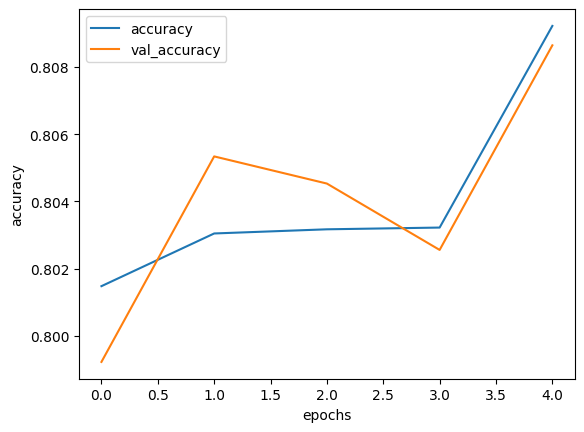

In [21]:
df_history = pd.DataFrame(historia.history)
df_history[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

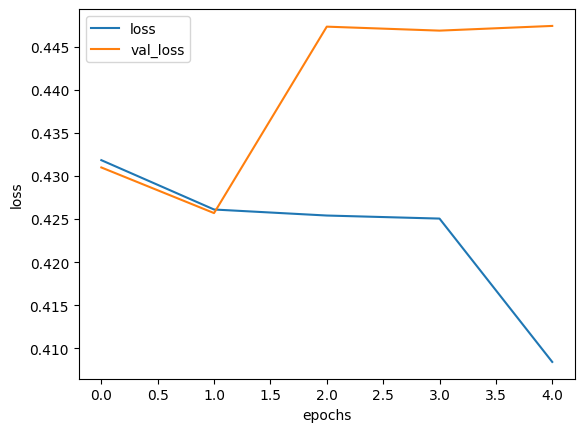

In [22]:
df_history = pd.DataFrame(historia.history)
df_history[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

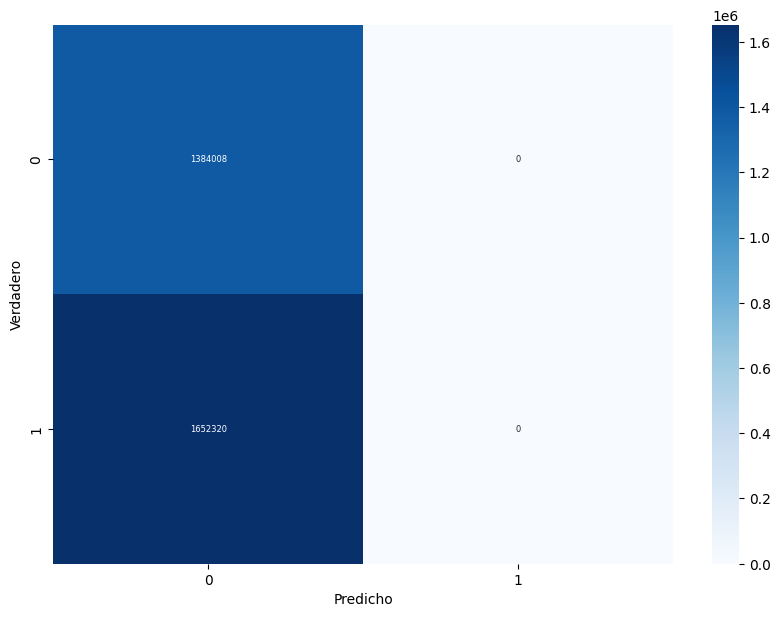

In [31]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val_a, y_pred_classes)

#Crear un mapa de calor con Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicho')
plt.ylabel('Verdadero')

# Mostrar el gráfico
plt.show()

MODELO CON SGD


In [25]:
modelo = tf.keras.Sequential()
# Definir las 4 entradas
 
modelo.add(tf.keras.layers.Dense(units=64, activation='relu', input_shape=(115,), kernel_regularizer=l2(0.01)))
modelo.add(tf.keras.layers.BatchNormalization())#mejora la tasa de parendizaje, evitando sobreajuste, ya que tb regulariza la funcion

# Capas ocultas
modelo.add(tf.keras.layers.Dense(units=64, activation="relu", input_dim=115))#relu, la mas comun,rapida y eficiente
modelo.add(tf.keras.layers.BatchNormalization())#mejora la tasa de parendizaje, evitando sobreajuste, ya que tb regulariza la funcion

modelo.add(Dropout(0.2))

modelo.add(tf.keras.layers.Dense(units=64, activation="elu", kernel_regularizer=l2(0.01)))
modelo.add(tf.keras.layers.BatchNormalization())

modelo.add(tf.keras.layers.Dense(units=64, activation='elu'))#eLU mejora la convergencia y la velocidad de entrenamiento
modelo.add(tf.keras.layers.BatchNormalization())

# Capa de salida
modelo.add(tf.keras.layers.Dense(units=1, activation='sigmoid')) # sigmoide para clasificacion binaria
#optimizador
optimizador= tf.keras.optimizers.SGD(learning_rate=0.005,
                                      momentum=0.9, #aporta inercia al proceso de optimizacion, acelerando la convergencia
                                      nesterov=True)# en True actualiza momentum demanera anticipada al gradiente, mejorando la estaboiilidad

# Compilar el modelo
modelo.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])
tf.keras.metrics.AUC(name='auc')

#detiene el entrenamiento si la metrica no mejora 
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

#reduce la tasa de aprendizaje cuando el rendimiento del conj. val no mejora
reduce_lr_callbacks = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)

#Guarda el modelo cuando mejora la métrica de validación
filepath = r'D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo_SGD.h5'
monitor = 'val_loss'
checkpoint_callbacks = ModelCheckpoint(filepath=filepath, monitor=monitor, verbose=1, save_best_only=True)

#visionado_tensorboard
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

callbacks_list = [reduce_lr_callbacks, early_stopping_callbacks, checkpoint_callbacks]

# Entrenar el modelo
historia = modelo.fit(X_train_a, y_train_a, batch_size=64, epochs=20,verbose=1,validation_split=0.1,callbacks=callbacks_list)

Epoch 1/20
128091/128096 [============================>.] - ETA: 0s - loss: 0.4588 - accuracy: 0.7987 - precision: 0.7360 - recall: 0.9823
Epoch 1: val_loss improved from inf to 0.42335, saving model to D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo_SGD.h5
128096/128096 [==============================] - 321s 2ms/step - loss: 0.4588 - accuracy: 0.7987 - precision: 0.7360 - recall: 0.9823 - val_loss: 0.4233 - val_accuracy: 0.8013 - val_precision: 0.7381 - val_recall: 0.9834 - lr: 0.0100
Epoch 2/20
128094/128096 [============================>.] - ETA: 0s - loss: 0.4257 - accuracy: 0.8006 - precision: 0.7367 - recall: 0.9857
Epoch 2: val_loss improved from 0.42335 to 0.41777, saving model to D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo_SGD.h5
128096/128096 [==============================] - 324s 3ms/step - loss: 0.4257 - accuracy: 0.8006 - precision: 0.7367 - recall: 0.9857 - val_loss: 0.4178 - val_accuracy: 0.8019 - val_precision: 0.7434 - val_recall: 0.9707 - lr: 0

In [26]:
modelo.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                7424      
                                                                 
 batch_normalization_12 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_13 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 64)               

In [27]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy, precision, recall = modelo.evaluate(X_val_a, y_val_a)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)


# Predicción
y_pred = modelo.predict(X_val_a)
y_pred_classes = np.argmax(y_pred, axis=1)

# Métricas de clasificación
print(classification_report(y_val_a, y_pred_classes))

94886/94886 [==============================] - 109s 1ms/step - loss: 0.3953 - accuracy: 0.8100 - precision: 0.7429 - recall: 0.9953
Loss: 0.39526069164276123
Accuracy: 0.8099691271781921
precision: 0.7428866028785706
recall: 0.9952545762062073
94886/94886 [==============================] - 87s 911us/step


c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.46      1.00      0.63   1384008
         1.0       0.00      0.00      0.00   1652320

    accuracy                           0.46   3036328
   macro avg       0.23      0.50      0.31   3036328
weighted avg       0.21      0.46      0.29   3036328



c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


valores similares ante anteriores modelo con Adams y uso de distintas unidades, sigue ganando la calse mayoritariam por lo que vamos avolver a repetir estas reds haciendo previante un ressempled

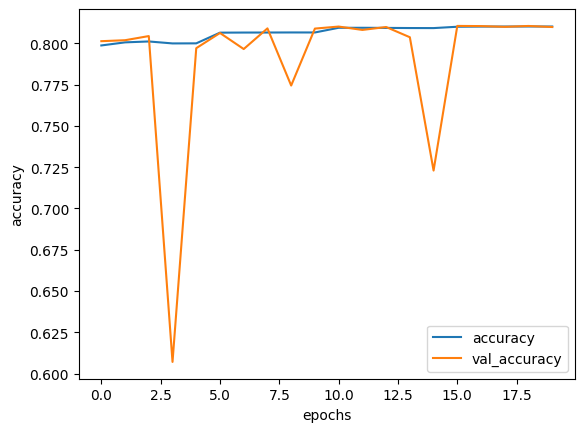

In [28]:
df_history = pd.DataFrame(historia.history)
df_history[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

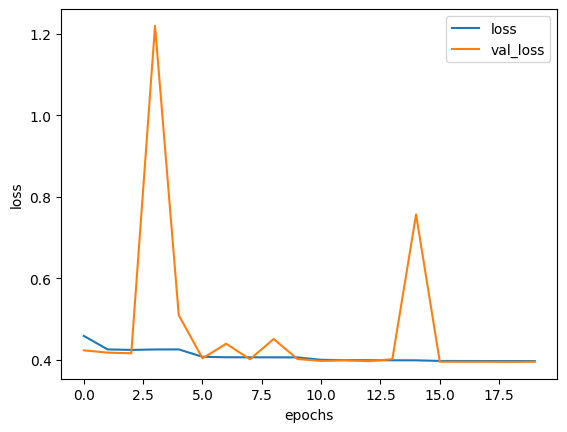

In [29]:
df_history = pd.DataFrame(historia.history)
df_history[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

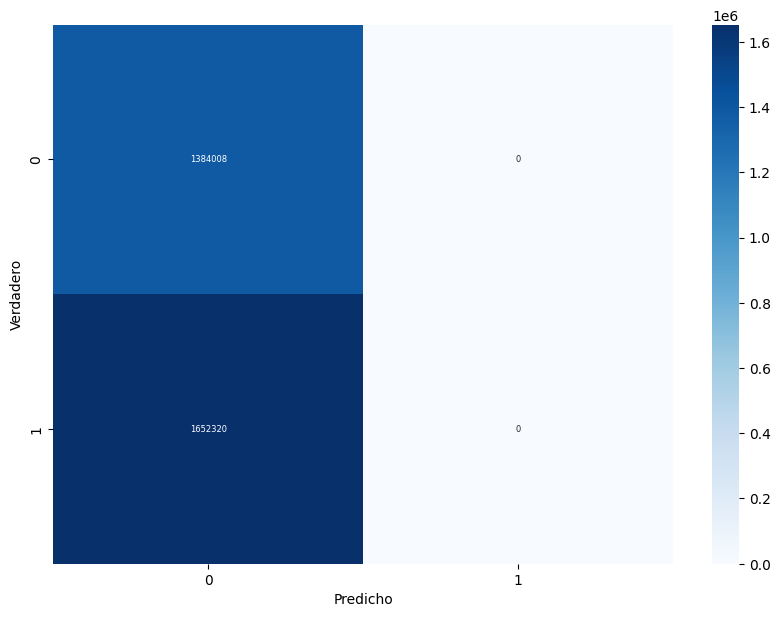

In [32]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val_a, y_pred_classes)

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicho')
plt.ylabel('Verdadero')

# Mostrar el gráfico
plt.show()

## APLICAMOS RESAMPLED A LA CLASE MINORITARIA

In [11]:
# Aplica submuestro, para reducir el número de observaciones de todas las clases menos la clase minoritaria
X=df_rn.drop(["Target"], axis=1)
y=df_rn["Target"]

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)


X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(11078059, 115)
(2769515, 115)
(11078059,)
(2769515,)


<Axes: xlabel='Target', ylabel='Count'>

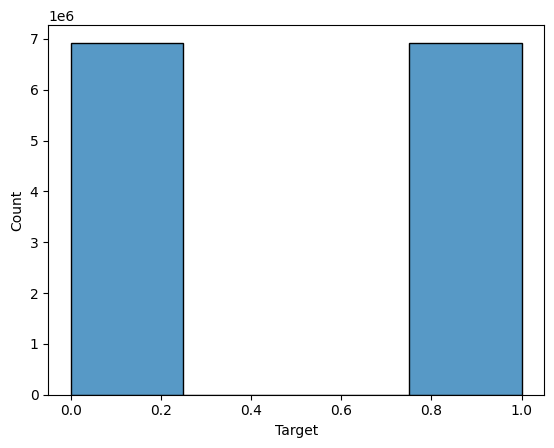

In [22]:
sns.histplot(y_resampled, bins=4)

In [12]:
# Convertir los datos a float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype("float32")
y_test = y_test.astype("float32")
X_val = X_val.astype("float32")
y_val = y_val.astype("float32")

In [13]:
X_train_a=X_train.values
y_train_a=y_train.values
X_test_a=X_test.values
y_test_a=y_test.values
X_val_a=X_val.values
y_val_a=y_val.values

## MODELOS SECUENCIALES BALANCEADOS Y SIN GPU

MODELO CON ADAM

In [25]:
modelo = tf.keras.Sequential()
# Definir las 4 entradas
 
modelo.add(tf.keras.layers.Dense(units=64, activation='relu', input_shape=(115,), kernel_regularizer=l2(0.01)))
modelo.add(tf.keras.layers.BatchNormalization())#mejora la tasa de parendizaje, evitando sobreajuste, ya que tb regulariza la funcion

# Capas ocultas
modelo.add(tf.keras.layers.Dense(units=32, activation="relu", input_dim=115))#relu, la mas comun,rapida y eficiente
modelo.add(tf.keras.layers.BatchNormalization())#mejora la tasa de parendizaje, evitando sobreajuste, ya que tb regulariza la funcion

modelo.add(Dropout(0.2))

modelo.add(tf.keras.layers.Dense(units=16, activation="elu", kernel_regularizer=l2(0.01)))
modelo.add(tf.keras.layers.BatchNormalization())

modelo.add(tf.keras.layers.Dense(units=8, activation='elu'))#eLU mejora la convergencia y la velocidad de entrenamiento
modelo.add(tf.keras.layers.BatchNormalization())

# Capa de salida
modelo.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  # sigmoide para clasificacion binaria
#optimizador
optimizador=Adam( learning_rate=0.01, # rebajo el learning rate por ser mas adecuado para un ajuste fino aunque tarde mas
                    beta_1=0.6, # influye en el gradiente pasado (1 mas al gradiente y 0 nada)
                    beta_2=0.4, #influye en los cuadrados de los gradientes pasados(1 mas a la varianza y 0 nada)
                    epsilon=1e-09, #es para prevenior divisiones entre 0
                    amsgrad=False)#es una variante de Adam y ayuda con la convergencia de ambos a evitar oscilaciones de los pesos durante la optimizacion"""

# Compilar el modelo
modelo.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])
tf.keras.metrics.AUC(name='auc')

#detiene el entrenamiento si la metrica no mejora 
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)

#reduce la tasa de aprendizaje cuando el rendimiento del conj. val no mejora
reduce_lr_callbacks = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)

#Guarda el modelo cuando mejora la métrica de validación
filepath = r'D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo_adam_resampled.h5'
monitor = 'val_loss'
checkpoint_callbacks = ModelCheckpoint(filepath=filepath, monitor=monitor, verbose=1, save_best_only=True)

#visionado_tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

callbacks_list = [early_stopping_callbacks, reduce_lr_callbacks, checkpoint_callbacks, tensorboard_callback]

# Entrenar el modelo
historia = modelo.fit(X_train_a, y_train_a, batch_size=32, epochs=10,verbose=1,validation_split=0.1,callbacks=callbacks_list)

Epoch 1/10
311545/311571 [============================>.] - ETA: 0s - loss: 0.4389 - accuracy: 0.7837 - precision: 0.7024 - recall: 0.9844
Epoch 1: val_loss improved from inf to 0.43760, saving model to D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo_adam_resampled.h5
311571/311571 [==============================] - 671s 2ms/step - loss: 0.4389 - accuracy: 0.7837 - precision: 0.7024 - recall: 0.9844 - val_loss: 0.4376 - val_accuracy: 0.7835 - val_precision: 0.7071 - val_recall: 0.9675 - lr: 0.0010
Epoch 2/10
311555/311571 [============================>.] - ETA: 0s - loss: 0.4322 - accuracy: 0.7857 - precision: 0.7032 - recall: 0.9884
Epoch 2: val_loss did not improve from 0.43760
311571/311571 [==============================] - 621s 2ms/step - loss: 0.4322 - accuracy: 0.7857 - precision: 0.7032 - recall: 0.9884 - val_loss: 0.4390 - val_accuracy: 0.7862 - val_precision: 0.7050 - val_recall: 0.9839 - lr: 0.0010
Epoch 3/10
311571/311571 [==============================] - ETA: 0s 

In [26]:
modelo.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                7424      
                                                                 
 batch_normalization_12 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_13 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 16)               

In [33]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy, precision, recall = modelo.evaluate(X_test_a, y_test_a)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)


# Predicción
y_pred = modelo.predict(X_val_a)
y_pred_classes = np.argmax(y_pred, axis=1)

# Métricas de clasificación
print(classification_report(y_val_a, y_pred_classes))

86548/86548 [==============================] - 82s 944us/step - loss: 0.4370 - accuracy: 0.7846 - precision: 0.7084 - recall: 0.9676
Loss: 0.43704232573509216
Accuracy: 0.7845828533172607
precision: 0.7084441184997559
recall: 0.9675958752632141
86548/86548 [==============================] - 63s 731us/step


c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67   1384044
         1.0       0.00      0.00      0.00   1385471

    accuracy                           0.50   2769515
   macro avg       0.25      0.50      0.33   2769515
weighted avg       0.25      0.50      0.33   2769515



c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


sIGUE PREDICIENDO PARA LA CLASE MALICIOUS, HABIENDO MEJORADO UNOS PUNTOS LA PRECISISION, HABIENDO MEJORADO TAMBIEN LA TSA F1-, ASI QUE EN RESUMEN Los resultados indican que el modelo tiene un buen desempeño en la identificación de la clase 0 (SENSIBILIDAD alta), pero tiene un desempeño muy bajo en la identificación de ejemplos de la clase 1 (precisión baja)

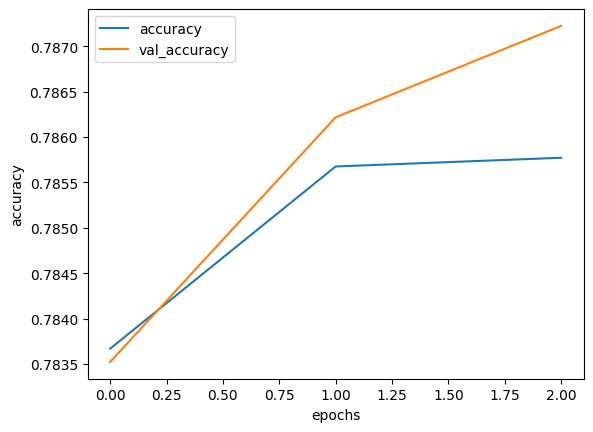

In [34]:
df_history = pd.DataFrame(historia.history)
df_history[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

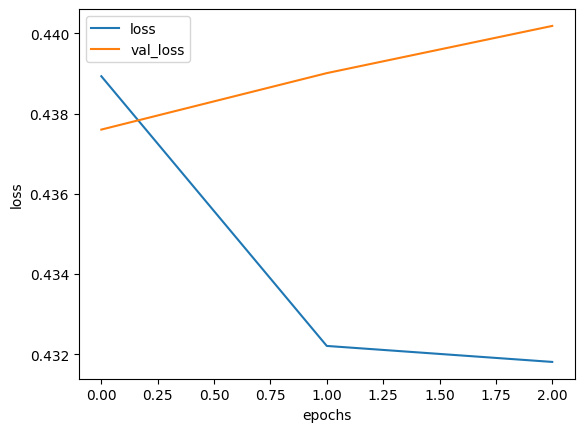

In [35]:
df_history = pd.DataFrame(historia.history)
df_history[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

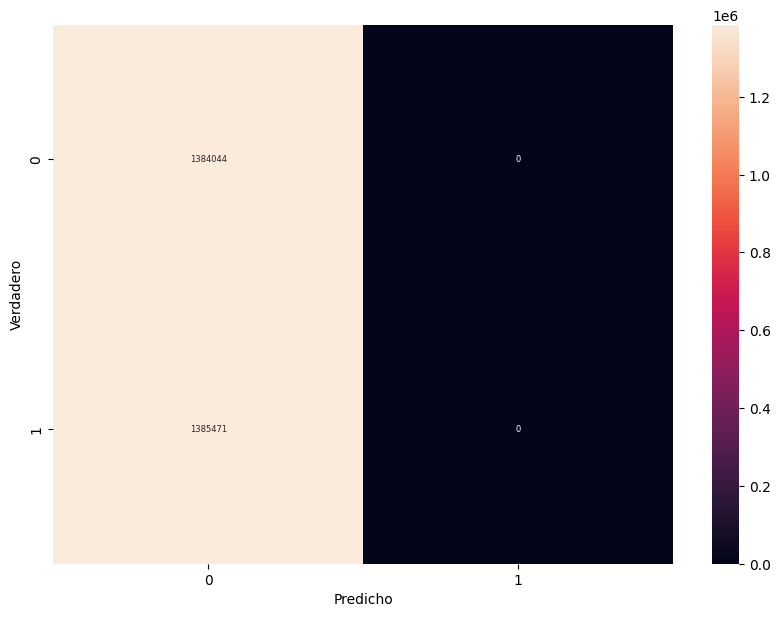

In [39]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test_a, y_pred_classes)

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')

# Mostrar el gráfico
plt.show()

MODELO CON SGD

In [14]:
modelo = tf.keras.Sequential()
# Definir las 4 entradas
 
modelo.add(tf.keras.layers.Dense(units=64, activation='relu', input_shape=(115,), kernel_regularizer=l2(0.01)))
modelo.add(tf.keras.layers.BatchNormalization())#mejora la tasa de parendizaje, evitando sobreajuste, ya que tb regulariza la funcion

# Capas ocultas
modelo.add(tf.keras.layers.Dense(units=64, activation="relu", input_dim=115))#relu, la mas comun,rapida y eficiente
modelo.add(tf.keras.layers.BatchNormalization())#mejora la tasa de parendizaje, evitando sobreajuste, ya que tb regulariza la funcion

modelo.add(Dropout(0.2))

modelo.add(tf.keras.layers.Dense(units=64, activation="elu", kernel_regularizer=l2(0.01)))
modelo.add(tf.keras.layers.BatchNormalization())

modelo.add(tf.keras.layers.Dense(units=64, activation='elu'))#eLU mejora la convergencia y la velocidad de entrenamiento
modelo.add(tf.keras.layers.BatchNormalization())

# Capa de salida
modelo.add(tf.keras.layers.Dense(units=1, activation='sigmoid')) # sigmoide para clasificacion binaria
#optimizador
optimizador= tf.keras.optimizers.SGD(learning_rate=0.005,
                                      momentum=0.9, #aporta inercia al proceso de optimizacion, acelerando la convergencia
                                      nesterov=True)# en True actualiza momentum demanera anticipada al gradiente, mejorando la estaboiilidad

# Compilar el modelo
modelo.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])
tf.keras.metrics.AUC(name='auc')

#detiene el entrenamiento si la metrica no mejora 
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

#reduce la tasa de aprendizaje cuando el rendimiento del conj. val no mejora
reduce_lr_callbacks = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)

#Guarda el modelo cuando mejora la métrica de validación
filepath = r'D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo_SGD.h5'
monitor = 'val_loss'
checkpoint_callbacks = ModelCheckpoint(filepath=filepath, monitor=monitor, verbose=1, save_best_only=True)

#visionado_tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

callbacks_list = [reduce_lr_callbacks, early_stopping_callbacks, checkpoint_callbacks]

# Entrenar el modelo
historia = modelo.fit(X_train_a, y_train_a, batch_size=64, epochs=30,verbose=1,validation_split=0.1,callbacks=callbacks_list)

Epoch 1/30
155782/155786 [============================>.] - ETA: 0s - loss: 0.4632 - accuracy: 0.7791 - precision: 0.7017 - recall: 0.9710
Epoch 1: val_loss improved from inf to 0.46988, saving model to D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo_SGD.h5
155786/155786 [==============================] - 333s 2ms/step - loss: 0.4632 - accuracy: 0.7791 - precision: 0.7017 - recall: 0.9710 - val_loss: 0.4699 - val_accuracy: 0.7691 - val_precision: 0.7023 - val_recall: 0.9334 - lr: 0.0100
Epoch 2/30
155779/155786 [============================>.] - ETA: 0s - loss: 0.4336 - accuracy: 0.7822 - precision: 0.7025 - recall: 0.9789
Epoch 2: val_loss improved from 0.46988 to 0.42775, saving model to D:\Cursos\REPOSITORIOS\DATASET\malware_total\logs\modelo_SGD.h5
155786/155786 [==============================] - 355s 2ms/step - loss: 0.4336 - accuracy: 0.7822 - precision: 0.7025 - recall: 0.9789 - val_loss: 0.4277 - val_accuracy: 0.7862 - val_precision: 0.7008 - val_recall: 0.9983 - lr: 0

In [15]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy, precision, recall = modelo.evaluate(X_test_a, y_test_a)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)


# Predicción
y_pred = modelo.predict(X_val_a)
y_pred_classes = np.argmax(y_pred, axis=1)

# Métricas de clasificación
print(classification_report(y_val_a, y_pred_classes))

86548/86548 [==============================] - 80s 919us/step - loss: 0.4233 - accuracy: 0.7879 - precision: 0.7055 - recall: 0.9888
Loss: 0.42327699065208435
Accuracy: 0.7879382967948914
precision: 0.7055380344390869
recall: 0.9887633919715881
86548/86548 [==============================] - 62s 712us/step


c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67   1384044
         1.0       0.00      0.00      0.00   1385471

    accuracy                           0.50   2769515
   macro avg       0.25      0.50      0.33   2769515
weighted avg       0.25      0.50      0.33   2769515



c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


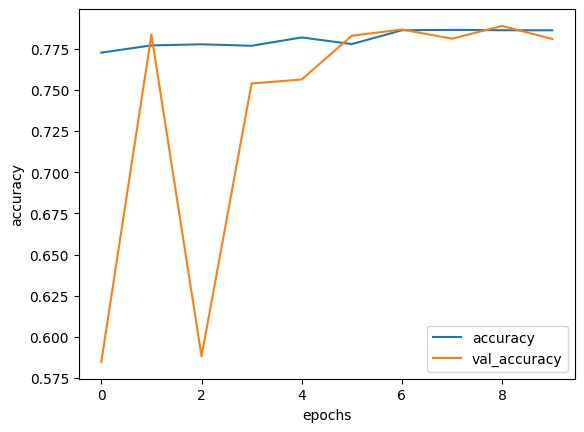

In [47]:
df_history = pd.DataFrame(historia.history)
df_history[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

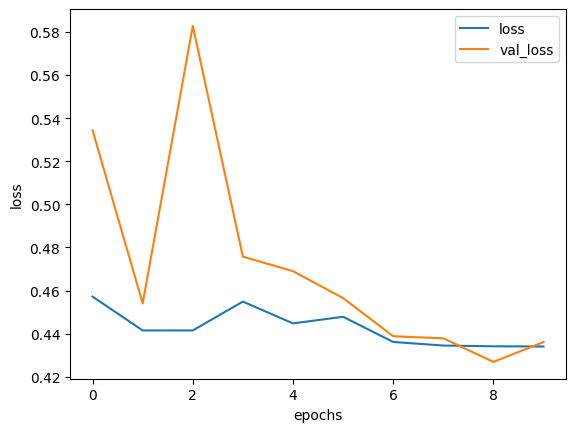

In [48]:
df_history = pd.DataFrame(historia.history)
df_history[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

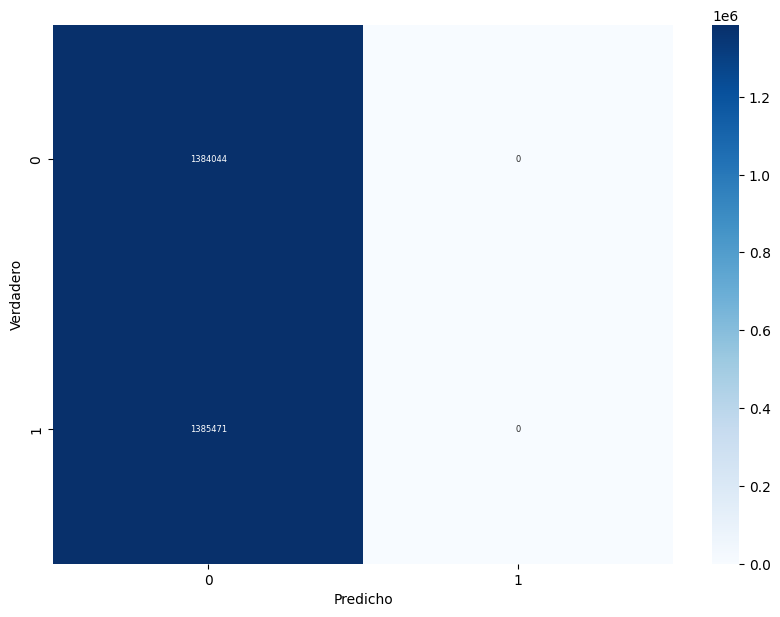

In [50]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test_a, y_pred_classes)

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d',cmap="Blues")
plt.xlabel('Predicho')
plt.ylabel('Verdadero')

# Mostrar el gráfico
plt.show()